In [279]:
from Simulator import *

In [280]:
def simulate1 (p, orgNum, genLen, clauseNum, weight):
    initial = [0] * genLen
    probability = [p] * genLen
    rounds = 50
    clauses = []
    for i in range(0, clauseNum):
        clauses.append(ConstraintSat([i + 1], weight))
    mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
    mySim.run()
    coeff = mySim.getExpCoeff()
    return coeff

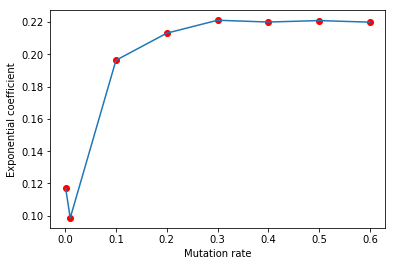

In [282]:
prob = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
coeff = []

for p in prob:
    coeff.append(simulate1(p, 100, 9, 8, 1))
    
plt.ylabel("Exponential coefficient")
plt.xlabel("Mutation rate")
plt.plot(prob, coeff, 'ro')
plt.plot(prob, coeff)
plt.show()

1
2
3
4
6
8
10
12
16
20
26
30


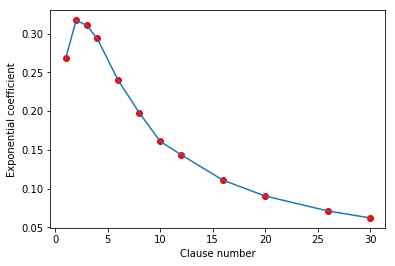

In [206]:
clauseNum = [1,2,3,4,6,8,10,12,16,20,26,30]
coeff = []
for cNum in clauseNum:
    print(cNum)
    coeff.append(simulate1(0.1, 100, 30, cNum, 1))
plt.ylabel("Exponential coefficient")
plt.xlabel("Clause number")
plt.plot(clauseNum, coeff, 'ro')
plt.plot(clauseNum, coeff)
plt.show()

1
2
3
4
6
8
10
12
16
20
26
30


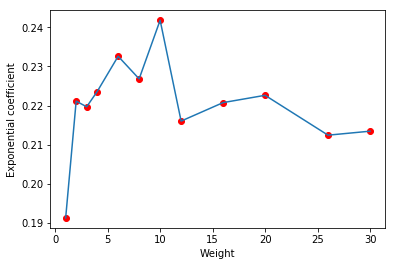

In [212]:
weights = [1,2,3,4,6,8,10,12,16,20,26,30]
coeff = []
for w in weights:
    print(w)
    coeff.append(simulate1(0.1, 100, 9, 8, w))
plt.ylabel("Exponential coefficient")
plt.xlabel("Weight")
plt.plot(weights, coeff, 'ro')
plt.plot(weights, coeff)
plt.show() #(results are pretty random, same for orgNum and genome length with fixed constrints)

2
4
6
8
10
12
16
20
26
30


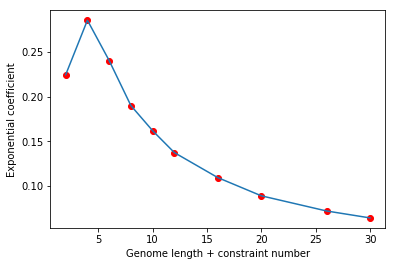

In [222]:
genLen = [2,4,6,8,10,12,16,20,26,30]
coeff = []
for l in genLen:
    print(l)
    coeff.append(simulate1(0.1, 100, l, l, 1))
plt.ylabel("Exponential coefficient")
plt.xlabel("Genome length + constraint number")
plt.plot(genLen, coeff, 'ro')
plt.plot(genLen, coeff)
plt.show()

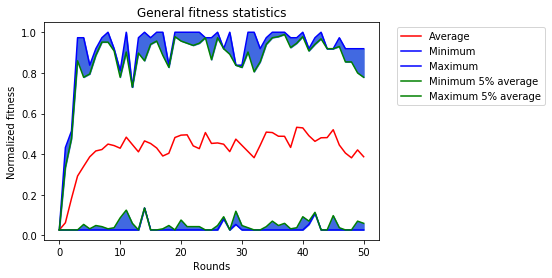

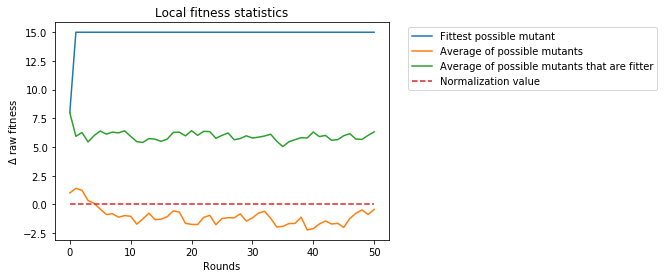

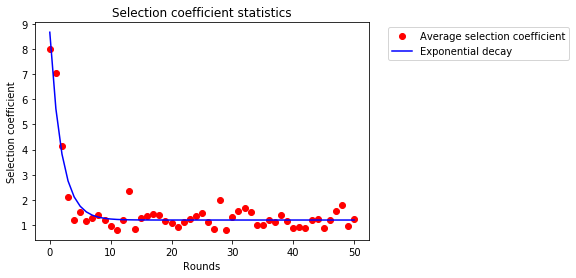

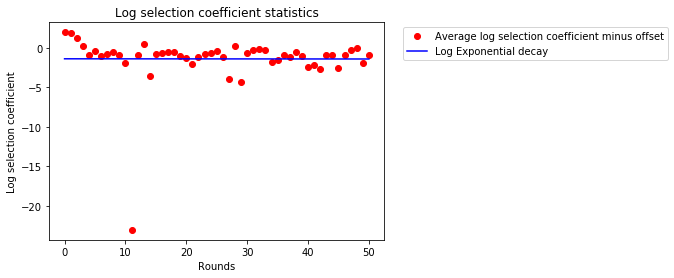

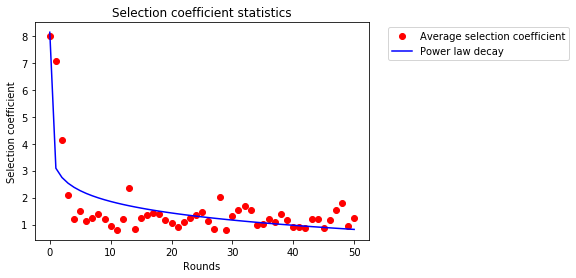

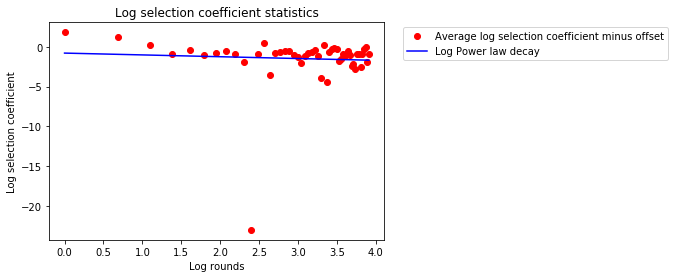

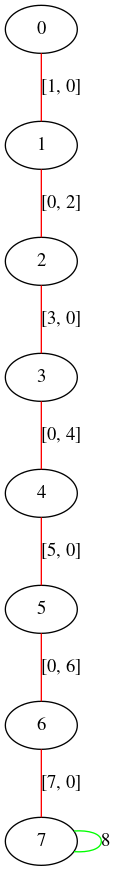

In [247]:
initial = [1, 0] * 4
probability = [0.1] * 8
rounds = 50
orgNum = 100
cons0 = ConstraintBinaryModelUnary(7, 8)
cons1 = ConstraintBinaryModelBinaryDifferent([0,1],[1,0])
cons2 = ConstraintBinaryModelBinaryDifferent([1,2],[0,2])
cons3 = ConstraintBinaryModelBinaryDifferent([2,3],[3,0])
cons4 = ConstraintBinaryModelBinaryDifferent([3,4],[0,4])
cons5 = ConstraintBinaryModelBinaryDifferent([4,5],[5,0])
cons6 = ConstraintBinaryModelBinaryDifferent([5,6],[0,6])
cons7 = ConstraintBinaryModelBinaryDifferent([6,7],[7,0])

constraints = [cons0, cons1,cons2,cons3,cons4,cons5,cons6,cons7]
mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

In [267]:
def simulate2 (p, orgNum, genLen, clauseNum, weight):
    initial = [0,1] * genLen
    probability = [p] * genLen * 2
    rounds = 50
    clauses = []
    x = 1
    clauses.append(ConstraintBinaryModelUnary(clauseNum - 1, 8))
    for i in range(0, clauseNum - 1):
        clauses.append(ConstraintBinaryModelBinaryDifferent([i,i + 1],[x,1 - x]))
        x = 1 - x
    mySim = Simulator(2, initial, probability, rounds, orgNum, clauses, None, 1)
    mySim.run()
    coeff = mySim.getExpCoeff()
    return coeff

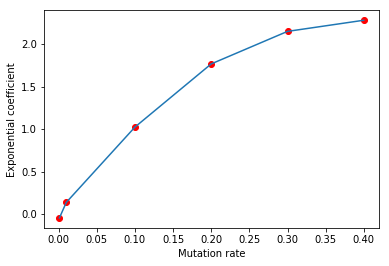

In [274]:
prob = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
coeff = []

for p in prob:
    c = simulate2(p, 100, 4, 8, 1)
    coeff.append(c)

plt.ylabel("Exponential coefficient")
plt.xlabel("Mutation rate")
plt.plot(prob, coeff, 'ro')
plt.plot(prob, coeff)
plt.show()

2
3
4
6
8
10
12
16
20
26
30


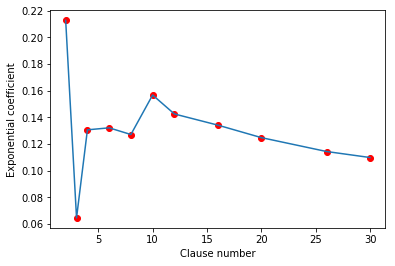

In [278]:
clauseNum = [2,3,4,6,8,10,12,16,20,26,30]
coeff = []
for cNum in clauseNum:
    print(cNum)
    c = simulate2(0.01, 100, 15, cNum, 1)
    coeff.append(c)
plt.ylabel("Exponential coefficient")
plt.xlabel("Clause number")
plt.plot(clauseNum, coeff, 'ro')
plt.plot(clauseNum, coeff)
plt.show()

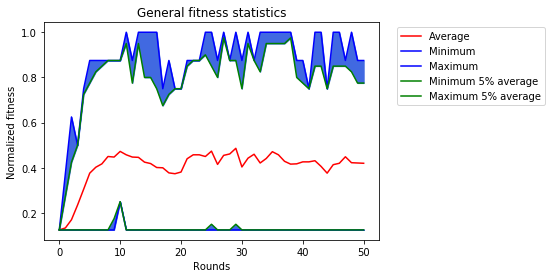

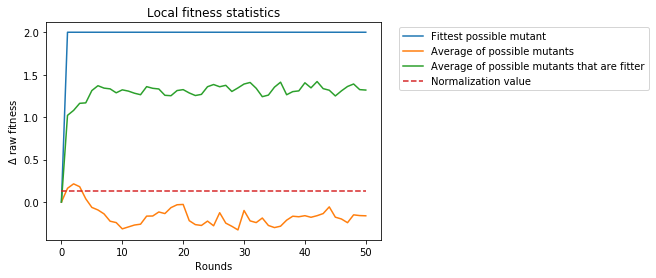

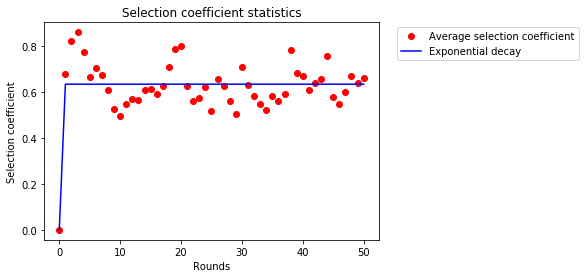

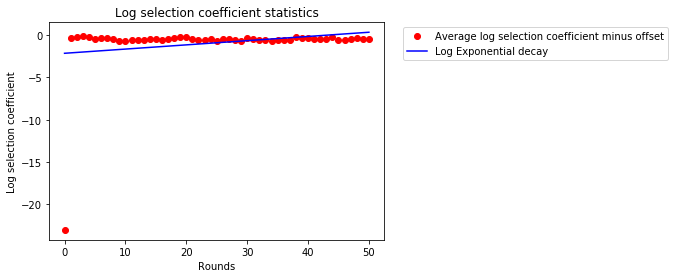

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: divide by zero encountered in power


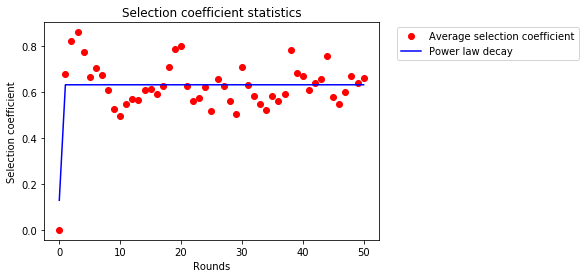

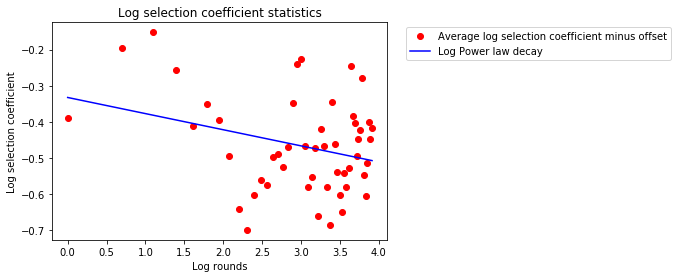

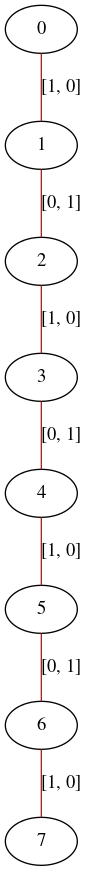

In [239]:
initial = [1, 0] * 4
probability = [0.1] * 8
rounds = 50
orgNum = 100
cons1 = ConstraintBinaryModelBinaryDifferent([0,1],[1,0])
cons2 = ConstraintBinaryModelBinaryDifferent([1,2],[0,1])
cons3 = ConstraintBinaryModelBinaryDifferent([2,3],[1,0])
cons4 = ConstraintBinaryModelBinaryDifferent([3,4],[0,1])
cons5 = ConstraintBinaryModelBinaryDifferent([4,5],[1,0])
cons6 = ConstraintBinaryModelBinaryDifferent([5,6],[0,1])
cons7 = ConstraintBinaryModelBinaryDifferent([6,7],[1,0])

constraints = [cons1,cons2,cons3,cons4,cons5,cons6,cons7]
mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

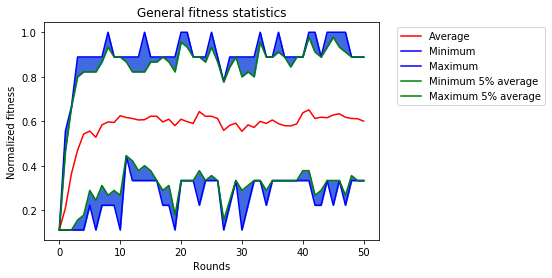

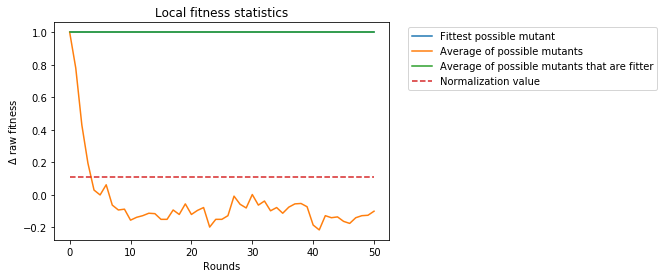

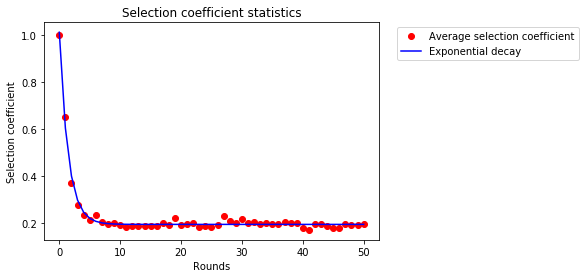

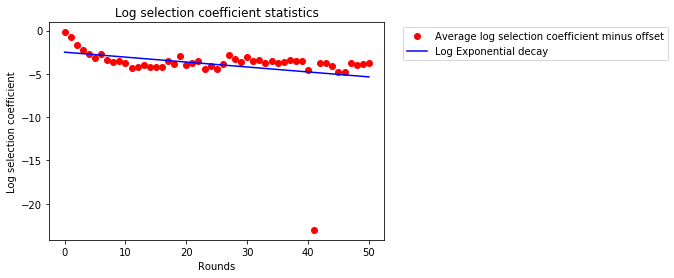

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: divide by zero encountered in power


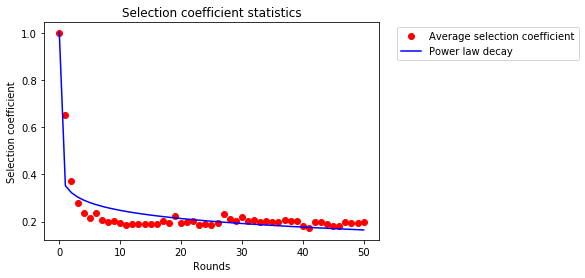

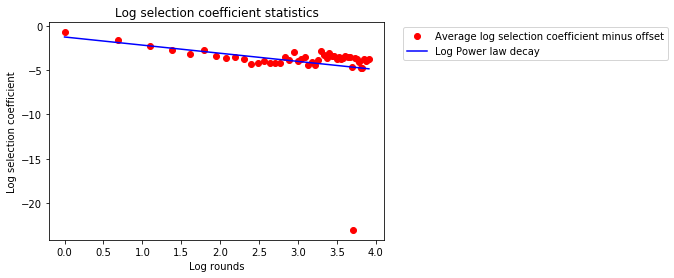

Constraint graph available only for binary constraints
CPU times: user 2.16 s, sys: 1.2 s, total: 3.36 s
Wall time: 1.58 s


In [203]:
%%time

initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = [0.1] * 8
rounds = 50
orgNum = 100
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
mySim.plotConstraintGraph()

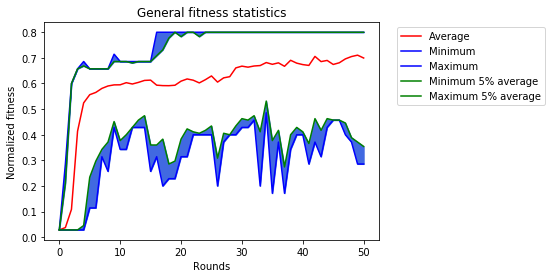

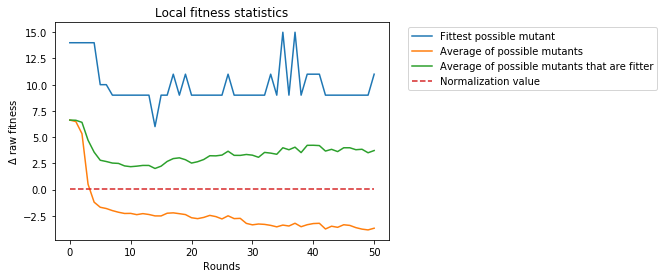

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:230: RuntimeWarning: overflow encountered in exp


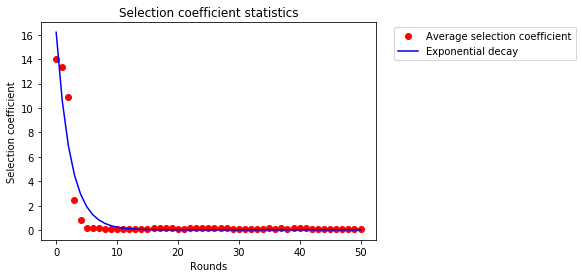

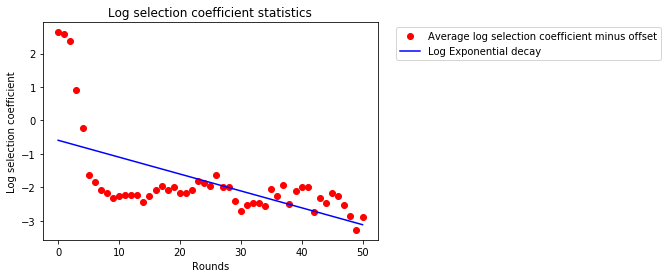

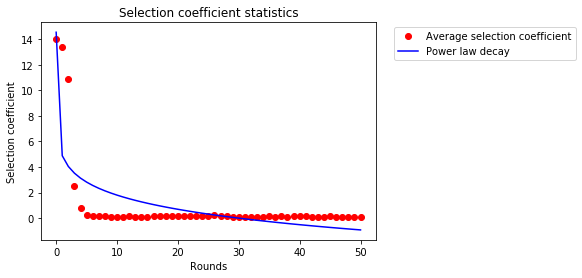

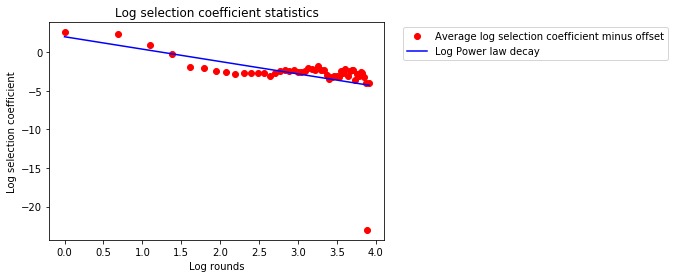

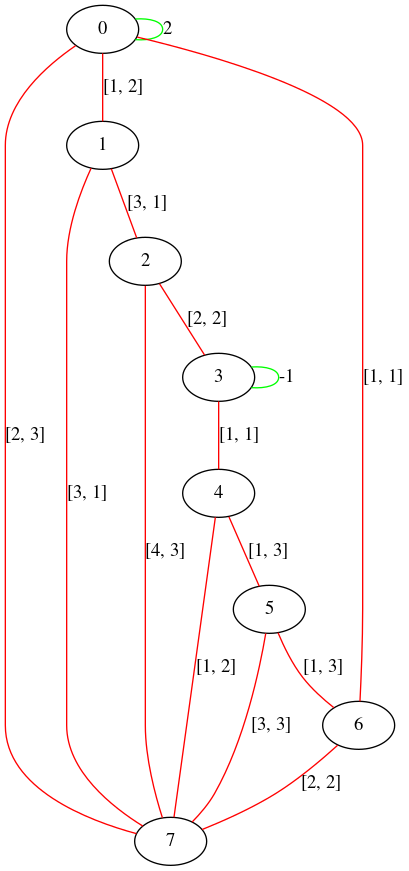

In [121]:
initial = [0] * 8
probability = [0.01] * 8
rounds = 50
orgNum = 100
cons1 = ConstraintBinaryModelUnary(0, 2)
cons2 = ConstraintBinaryModelUnary(3, -1)
cons3 = ConstraintBinaryModelBinaryDifferent([0,7],[2,3])
cons4 = ConstraintBinaryModelBinaryDifferent([0,1],[1,2])
cons5 = ConstraintBinaryModelBinaryDifferent([1,7],[3,1])
cons6 = ConstraintBinaryModelBinaryDifferent([1,2],[3,1])
cons7 = ConstraintBinaryModelBinaryDifferent([7,2],[4,3])
cons8 = ConstraintBinaryModelBinaryDifferent([2,3],[2,2])
cons9 = ConstraintBinaryModelBinaryDifferent([4,3],[1,1])
cons10 = ConstraintBinaryModelBinaryDifferent([4,7],[1,2])
cons11 = ConstraintBinaryModelBinaryDifferent([4,5],[1,3])
cons12 = ConstraintBinaryModelBinaryDifferent([7,5],[3,3])
cons13 = ConstraintBinaryModelBinaryDifferent([6,5],[1,3])
cons14 = ConstraintBinaryModelBinaryDifferent([6,7],[2,2])
cons15 = ConstraintBinaryModelBinaryDifferent([6,0],[1,1])
constraints = [cons1,cons2,cons3,cons4,cons5,cons6,cons7,cons8,cons9,cons10,cons11,cons12,cons13,cons14,cons15]

mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

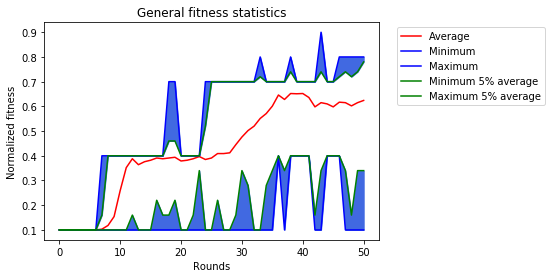

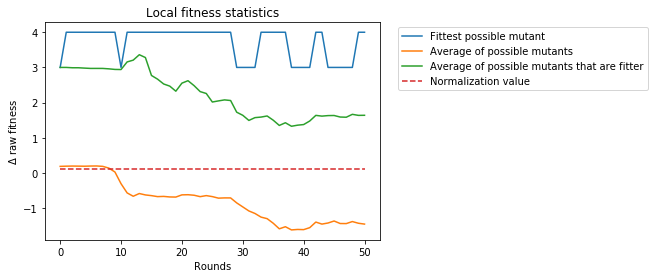

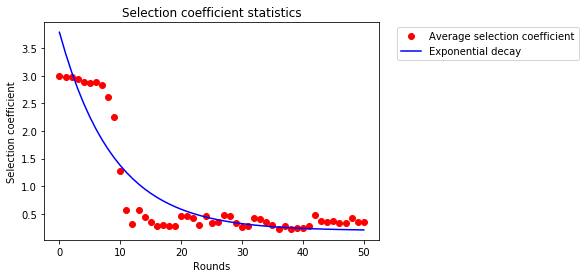

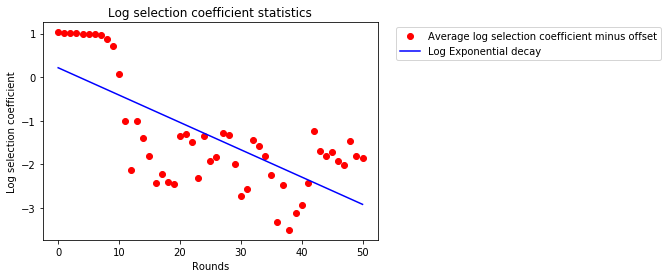

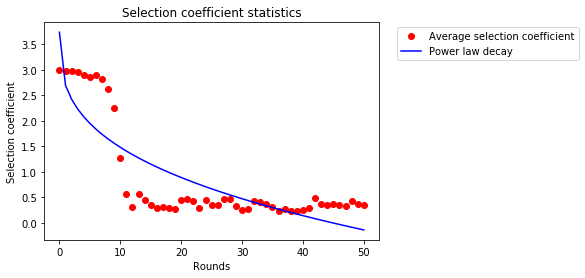

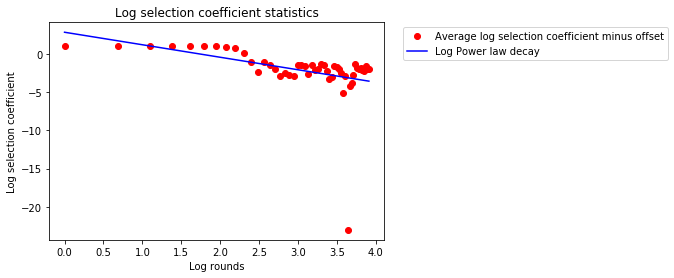

CPU times: user 2.3 s, sys: 1.66 s, total: 3.96 s
Wall time: 1.59 s


In [122]:
%%time

initial = [0,0,0,0,0,0,0,0]
probability = [0.01] * 8
rounds = 50
orgNum = 100
cons1 = ConstraintWCSP(([0,1],[["red", "red"]]), 2)
cons2 = ConstraintWCSP(([2,3],[["blue", "yellow"]]), 3)
cons3 = ConstraintWCSP(([5,6,7],[["blue", "red", "red"]]), 3)
cons4 = ConstraintWCSP(([1,6,7],[["yellow", "red", "red"]]), 1)
constraints = [cons1, cons2, cons3, cons4]
domain = ["blue", "red", "yellow"]
domains = [domain] * 8

mySim = Simulator(4, initial, probability, rounds, orgNum, constraints, domains, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

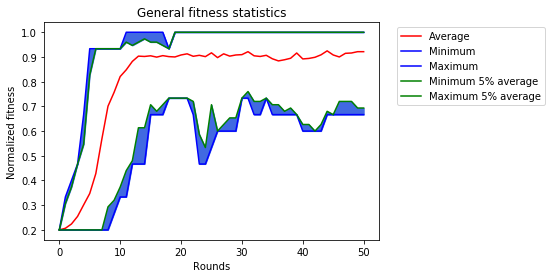

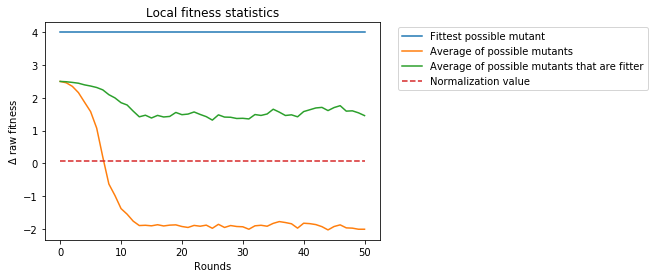

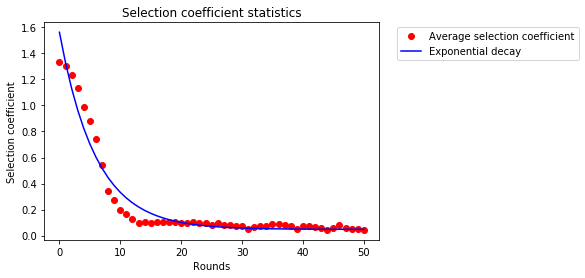

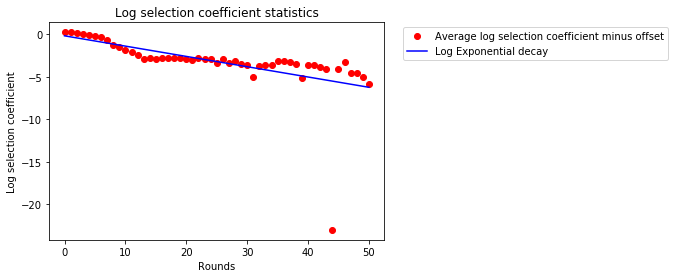

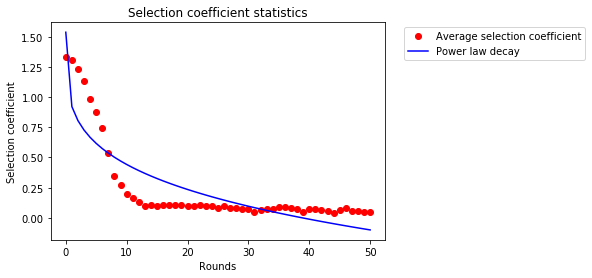

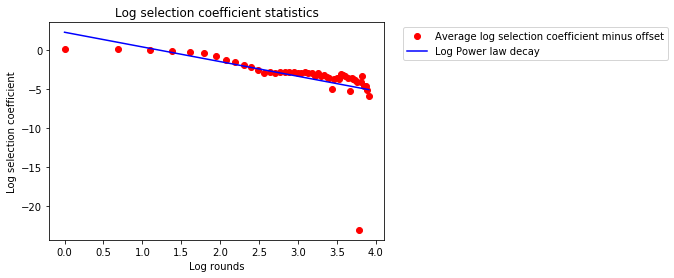

In [123]:
initial = [0,0,0]
probability = [0.01,0.02,0.01]
rounds = 50
orgNum = 100
def myFunc(args):
    return sum(args)
cons = ConstraintVCSP([0,1,2],(myFunc,15))
domain = [1,2,3,4,5]
domains = [domain] * 3
constraints = [cons]

mySim = Simulator(3, initial, probability, rounds, orgNum, constraints, domains, 0)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

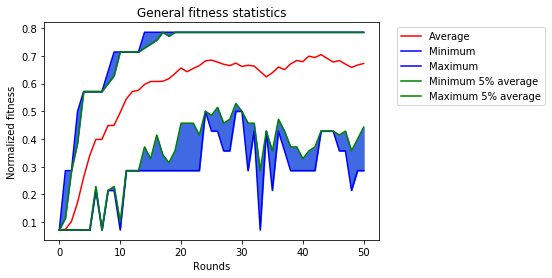

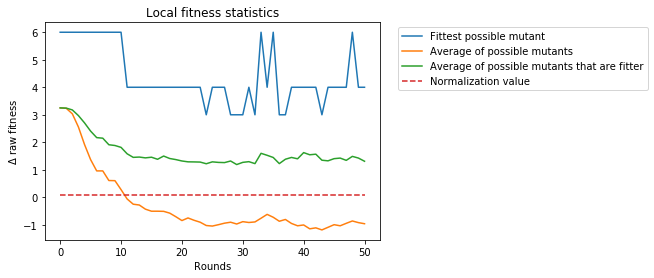

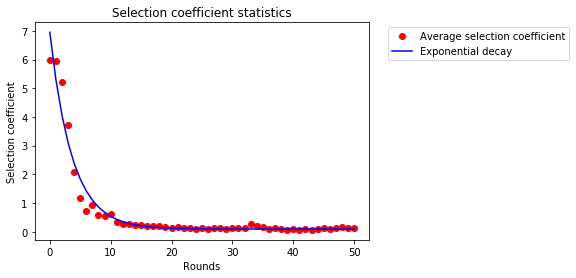

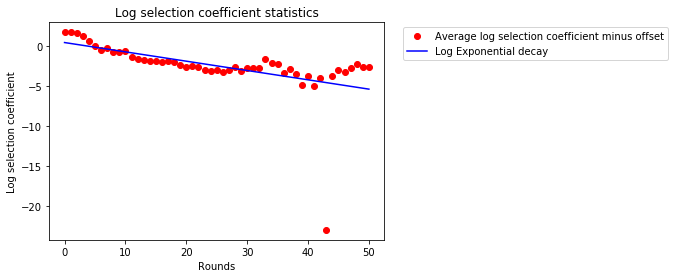

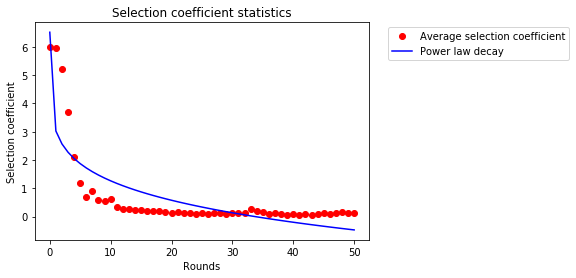

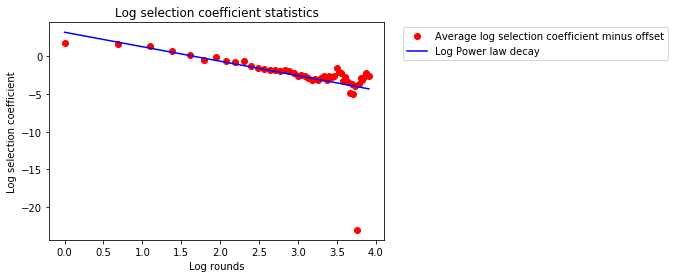

In [124]:
initial = [0] * 8
probability = [0.01] * 8
rounds = 50
orgNum = 100
cons3 = ConstraintBinaryModelBinaryDifferent([0,7],[1,1])
cons4 = ConstraintBinaryModelBinaryDifferent([0,1],[1,1])
cons5 = ConstraintBinaryModelBinaryDifferent([1,7],[1,1])
cons6 = ConstraintBinaryModelBinaryDifferent([1,2],[1,1])
cons7 = ConstraintBinaryModelBinaryDifferent([7,2],[1,1])
cons8 = ConstraintBinaryModelBinaryDifferent([2,3],[1,1])
cons9 = ConstraintBinaryModelBinaryDifferent([4,3],[1,1])
cons10 = ConstraintBinaryModelBinaryDifferent([4,7],[1,1])
cons11 = ConstraintBinaryModelBinaryDifferent([4,5],[1,1])
cons12 = ConstraintBinaryModelBinaryDifferent([7,5],[1,1])
cons13 = ConstraintBinaryModelBinaryDifferent([6,5],[1,1])
cons14 = ConstraintBinaryModelBinaryDifferent([6,7],[1,1])
cons15 = ConstraintBinaryModelBinaryDifferent([6,0],[1,1])
constraints = [cons3,cons4,cons5,cons6,cons7,cons8,cons9,cons10,cons11,cons12,cons13,cons14,cons15]

mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

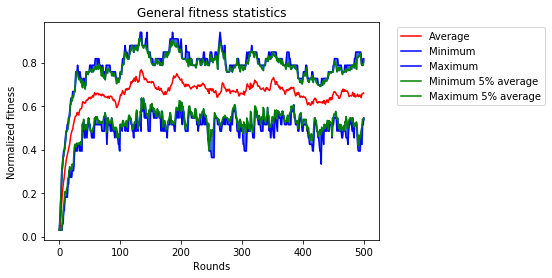

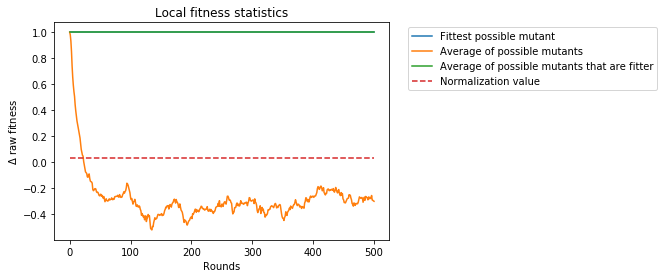

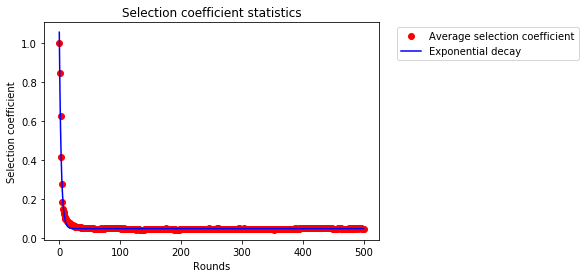

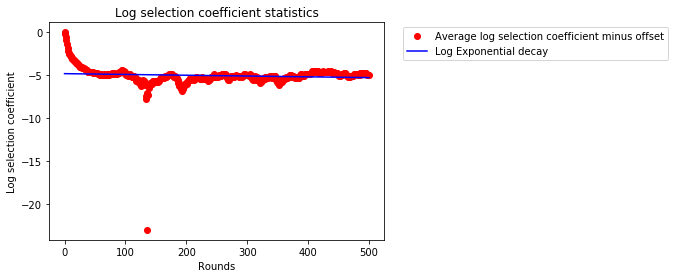

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:232: RuntimeWarning: divide by zero encountered in power


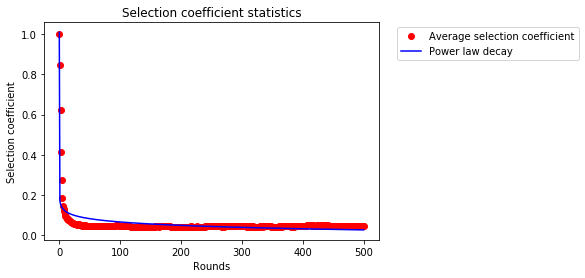

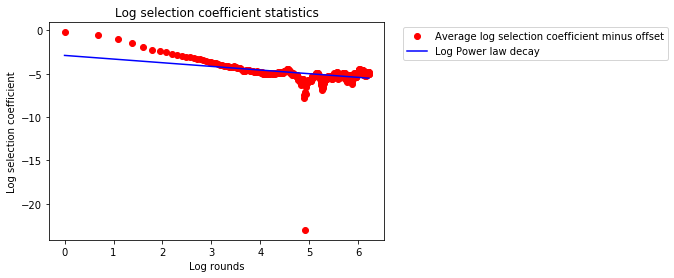

CPU times: user 44.2 s, sys: 1.22 s, total: 45.4 s
Wall time: 43.7 s


In [125]:
%%time

initial = [0] * 32
probability = [0.01] * 32
rounds = 500
orgNum = 100
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clause9 = ConstraintSat([9],1)
clause10 = ConstraintSat([10],1)
clause11 = ConstraintSat([11],1)
clause12 = ConstraintSat([12],1)
clause13 = ConstraintSat([13],1)
clause14 = ConstraintSat([14],1)
clause15 = ConstraintSat([15],1)
clause16 = ConstraintSat([16],1)
clause17 = ConstraintSat([17],1)
clause18 = ConstraintSat([18],1)
clause19 = ConstraintSat([19],1)
clause20 = ConstraintSat([20],1)
clause21 = ConstraintSat([21],1)
clause22 = ConstraintSat([22],1)
clause23 = ConstraintSat([23],1)
clause24 = ConstraintSat([24],1)
clause25 = ConstraintSat([25],1)
clause26 = ConstraintSat([26],1)
clause27 = ConstraintSat([27],1)
clause28 = ConstraintSat([28],1)
clause29 = ConstraintSat([29],1)
clause30 = ConstraintSat([30],1)
clause31 = ConstraintSat([31],1)
clause32 = ConstraintSat([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

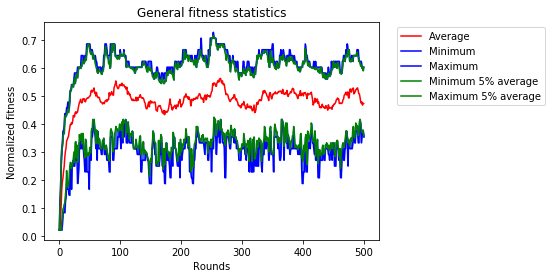

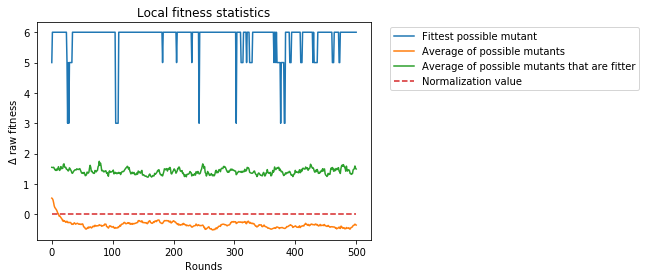

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: overflow encountered in multiply


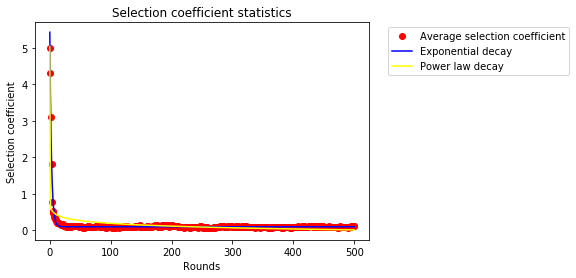

CPU times: user 1min 15s, sys: 11.9 ms, total: 1min 15s
Wall time: 1min 15s


In [59]:
%%time

initial = [0] * 32
probability = [0.01] * 32
rounds = 500
orgNum = 100
clause1 = ConstraintSat([1,5,7],1)
clause2 = ConstraintSat([2,1,3],2)
clause3 = ConstraintSat([-3,5,7],1)
clause4 = ConstraintSat([4,2],1)
clause5 = ConstraintSat([-5,3],2)
clause6 = ConstraintSat([-6,18],1)
clause7 = ConstraintSat([7,23],1)
clause8 = ConstraintSat([8,-19],3)
clause9 = ConstraintSat([9,-1],1)
clause10 = ConstraintSat([10,-6],1)
clause11 = ConstraintSat([11,-12,-22],2)
clause12 = ConstraintSat([12,11],1)
clause13 = ConstraintSat([13,14],1)
clause14 = ConstraintSat([14,-1],5)
clause15 = ConstraintSat([15,-29],1)
clause16 = ConstraintSat([16,32],1)
clause17 = ConstraintSat([17,-31],1)
clause18 = ConstraintSat([18,5],1)
clause19 = ConstraintSat([19,4],1)
clause20 = ConstraintSat([20,17],3)
clause21 = ConstraintSat([21,-7],1)
clause22 = ConstraintSat([22,-2],1)
clause23 = ConstraintSat([-23,4],1)
clause24 = ConstraintSat([24,-7],1)
clause25 = ConstraintSat([25,-6],1)
clause26 = ConstraintSat([26,-2],1)
clause27 = ConstraintSat([27],2)
clause28 = ConstraintSat([28],1)
clause29 = ConstraintSat([29],3)
clause30 = ConstraintSat([30],1)
clause31 = ConstraintSat([31],2)
clause32 = ConstraintSat([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

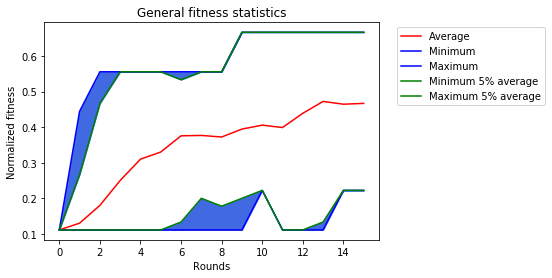

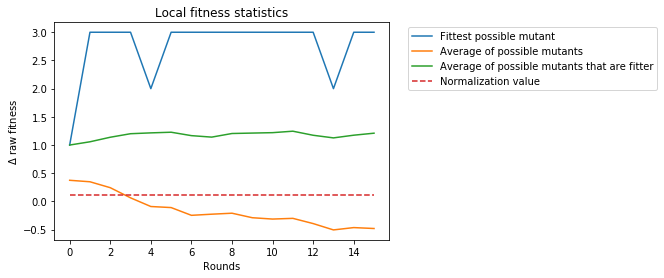

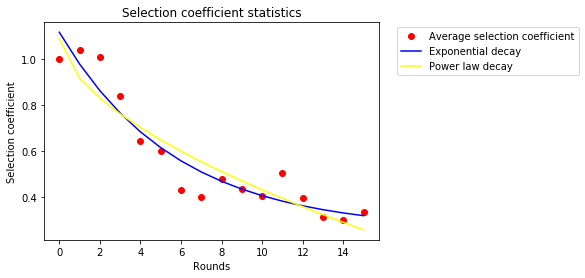

CPU times: user 922 ms, sys: 0 ns, total: 922 ms
Wall time: 918 ms


In [149]:
%%time

initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = [0.05] * 8
rounds = 15
orgNum = 100
clause1 = ConstraintSat([1,2,3],1)
clause2 = ConstraintSat([5,-4,7],1)
clause3 = ConstraintSat([6,7],1)
clause4 = ConstraintSat([1,-2],1)
clause5 = ConstraintSat([5,8],1)
clause6 = ConstraintSat([6,-8],1)
clause7 = ConstraintSat([7,-3],1)
clause8 = ConstraintSat([8,3],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

In [ ]:
#Observations:
#    Under this model, they tend to converge to an optimum quite fast
    
#What to do:
#    How to select the children / try various methods
#    For local statistics, how to plot the individuals
#    Use joyplots

[3]
